In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')



In [2]:
# import dei moduli

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf



In [4]:
!wget https://politecnicobari-my.sharepoint.com/:u:/g/personal/marco_scarpetta_poliba_it/EWPUBcglPk9Iigof03DZ86gB2Lx8KK8bFCSEbYSXE4KyCQ?download=1 -O /content/lines.npz
data = np.load('/content/lines.npz')

# lunghezza del lato delle immagini in pixel
img_size = 64


--2021-01-19 14:52:12--  https://politecnicobari-my.sharepoint.com/:u:/g/personal/marco_scarpetta_poliba_it/EWPUBcglPk9Iigof03DZ86gB2Lx8KK8bFCSEbYSXE4KyCQ?download=1
Resolving politecnicobari-my.sharepoint.com (politecnicobari-my.sharepoint.com)... 52.105.138.27
Connecting to politecnicobari-my.sharepoint.com (politecnicobari-my.sharepoint.com)|52.105.138.27|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/marco_scarpetta_poliba_it/Documents/data/esempi/lines.npz?originalPath=aHR0cHM6Ly9wb2xpdGVjbmljb2JhcmktbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvbWFyY29fc2NhcnBldHRhX3BvbGliYV9pdC9FV1BVQmNnbFBrOUlpZ29mMDNEWjg2Z0IyTHg4S0s4YkZDU0ViWVNYRTRLeUNRP3J0aW1lPUVVNTd6b204MkVn [following]
--2021-01-19 14:52:13--  https://politecnicobari-my.sharepoint.com/personal/marco_scarpetta_poliba_it/Documents/data/esempi/lines.npz?originalPath=aHR0cHM6Ly9wb2xpdGVjbmljb2JhcmktbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvbWFyY29fc2NhcnBldHRhX3BvbGliYV9pdC9FV1BVQmNnbFB

In [5]:
# %% lista degli array contenuti nel file del dataset
list(data.keys())


['training_images',
 'training_labels',
 'validation_images',
 'validation_labels']

In [6]:
 # %% dimensioni dell'array contenente le immagini di training

 data['training_images'].shape

(50000, 64, 64)

In [7]:
# %% dimensioni del vettore delle label che rappresentano le lunghezze delle immagini

data['training_labels'].shape

(50000,)

In [8]:
# %% preparazione del dataset

training_labels_px = data['training_labels']
validation_labels_px = data['validation_labels']

# unione dei vettori contenenti le label
labels_px = np.hstack([training_labels_px, validation_labels_px])

# calcolo dei valori minimi e massimi delle lunghezze
labels_px_min = np.min(labels_px)
labels_px_max = np.max(labels_px)
labels_px_range = labels_px_max - labels_px_min

# labels normalizzati nell'intervallo [0,1]
training_labels = training_labels_px/labels_px_range
validation_labels = validation_labels_px/labels_px_range

# caricamento immagini del dataset
training_images = data['training_images']
validation_images = data['validation_images']


<function matplotlib.pyplot.show>

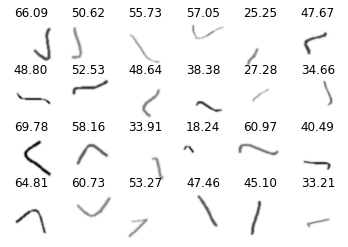

In [9]:
# %% visualizzo alcuni esempi del dataset
rows = 4
cols = 6

start = 1000

for i in range(rows*cols):
  plt.subplot(rows, cols, i+1)
  img = training_images[start + i]
  plt.imshow(img, cmap='Greys', vmin=0, vmax=1)
  plt.axis('off')
  plt.title('{:.2f}'.format(training_labels_px[start+i]))
plt.show

In [64]:
# %% costruzione della rete neurale per la misura della lunghezza della linea presente in ogni immagine

# livello d'ingresso
inputs = tf.keras.Input(shape=(img_size,img_size))
x = tf.keras.layers.Reshape([img_size, img_size, 1])(inputs)

# sequenza di layers convoluzionali con  attivazione 'reLu' seguiti da max pooling
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
#x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(128,3, activation= 'relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D()(x)

# inserisco layer per appiattire il tensore
x = tf.keras.layers.Flatten()(x)

# strato di layers densamente connessi
x = tf.keras.layers.Dense(16,activation='relu')(x)
# x = tf.keras.layers.Dense(8,activation='relu')(x)
# livello di output
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# inizializzazione del modello
model = tf.keras.Model(inputs, outputs) 

# compilazione del modello

model.compile('adam', loss='MSE', metrics=['accuracy'])

model.summary()






Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64)]          0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 128)       0   

In [65]:
# %% training

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(training_images, training_labels,
                    validation_data=(validation_images, validation_labels),
                    epochs=100, callbacks=early_stopping)

Epoch 1/100
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0086 - accuracy: 0.0000e+00 - val_loss: 9.9383e-04 - val_accuracy: 0.0000e+00
Epoch 2/100
1563/1563 [==============================] - 18s 12ms/step - loss: 7.8760e-04 - accuracy: 0.0000e+00 - val_loss: 8.1925e-04 - val_accuracy: 0.0000e+00
Epoch 3/100
1563/1563 [==============================] - 19s 12ms/step - loss: 4.4915e-04 - accuracy: 0.0000e+00 - val_loss: 3.3579e-04 - val_accuracy: 0.0000e+00
Epoch 4/100
1563/1563 [==============================] - 19s 12ms/step - loss: 3.3316e-04 - accuracy: 0.0000e+00 - val_loss: 8.5249e-04 - val_accuracy: 0.0000e+00
Epoch 5/100
1563/1563 [==============================] - 18s 12ms/step - loss: 3.5141e-04 - accuracy: 0.0000e+00 - val_loss: 2.2390e-04 - val_accuracy: 0.0000e+00
Epoch 6/100
1563/1563 [==============================] - 18s 12ms/step - loss: 2.7172e-04 - accuracy: 0.0000e+00 - val_loss: 2.3640e-04 - val_accuracy: 0.0000e+00
Epoch 7/100
1563/1563 [===

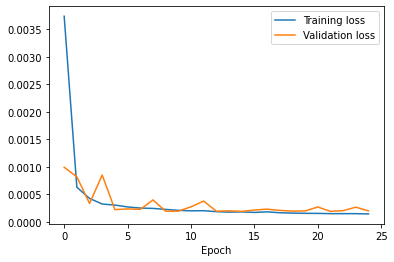

In [66]:
# %% grafico del processo di training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

In [86]:
# %% stima delle lunghezze delle linee del validation set

validation_labels_hat = model.predict(validation_images)

# riconverto le misure in pixel

# validation_labels_hat_px = validation_labels_hat*labels_px_range
vl_hat_px = validation_labels_hat*labels_px_range
validation_labels_hat_px = np.ndarray.flatten(vl_hat_px)

# display(validation_labels_px)
# display(validation_labels_hat_px)

# display(validation_labels_hat_px_array)


array([46.508698, 36.286263, 33.43077 , ..., 59.648247, 38.3533  ,
       42.647457], dtype=float32)

(10000,)

<function matplotlib.pyplot.show>

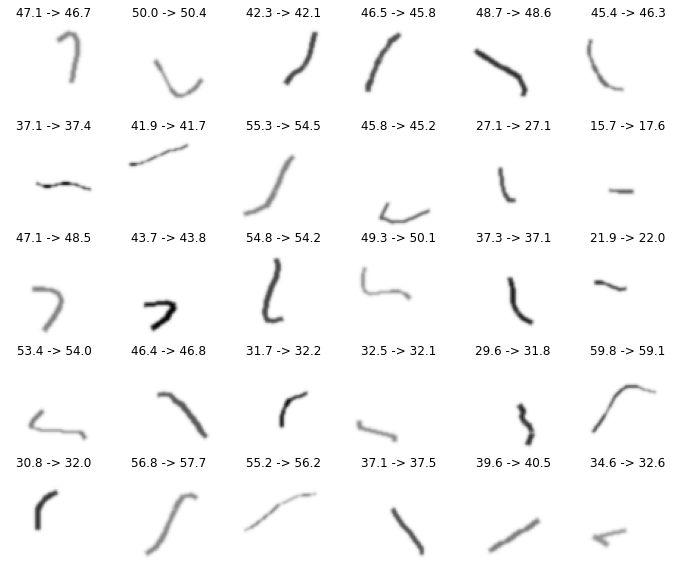

In [68]:
# visualizzazione delle stime di alcune lunghezze

rows = 5
cols = 6

start = 1000

plt.figure(figsize=(12,10))
for i in range(rows*cols):
  plt.subplot(rows, cols, i+1)
  img = validation_images[start + i]
  plt.imshow(img, cmap='Greys', vmin=0, vmax=1)
  plt.axis('off')
  plt.title('{:.1f} -> {:.1f}'.format(validation_labels_px[start+i],
                                      validation_labels_hat_px[start+i]))
plt.show

"Bias dell'errore: -0.18"

'Incertezza standard: 0.96'

'Incertezza estesa con cp = 95%: 1.89'

'Incertezza di caso peggiore: 12.23'

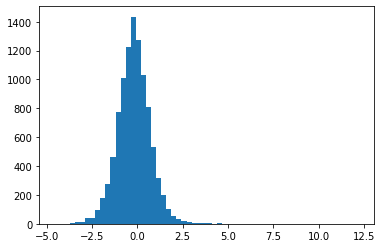

In [100]:
# %% Calcolo il vettore degli errori nella predizione del validation set

error = validation_labels_px - validation_labels_hat_px
# display (error[1001])

plt.hist(error,60,align= 'mid')

# calcolo la media degli errori
average_error = np.mean(error)
display("Bias dell'errore: {:.2f}".format(average_error))

# calcolo della deviazione standard dell'errore

u_error = np.std(error)
display("Incertezza standard: {:.2f}".format(u_error))

# calcolo l'incertezza estesa con probabilità di copertura pari al 95%
cp = 95/100
# sappiamo che ad una probabilità di copertura del 95% corrisponde un coefficiente
# di copertura pari a:
k = 1.96
U95_error = k*u_error
display("Incertezza estesa con cp = 95%: {:.2f}".format(U95_error))

# calcolo l'incertezza di caso peggiore come massimo modulo dell'errore
U100_error = np.max(np.abs(error))
display("Incertezza di caso peggiore: {:.2f}".format(U100_error))